In [2]:
# Импорт необходимых библиотек
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import date
import seaborn as sns
import itertools
from time import time
import holidays
import prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Установка параметров отображения для DataFrame pandas
pd.set_option ('display.max_columns', 599)
pd.set_option ('display.max_rows', 599)
# Настройка проекта Google Cloud и учетных данных
project_id = 'kolesa-android-app'
credentials = 'kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)

In [4]:
# Запрос данных из таблицы BigQuery
q = "SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"
data = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')
#data = pd.read_csv('Data/data.csv')
data.head()

Downloading: 100%|█████████████████████████████████████████████████████████████|


event_date      y
0  2020-01-01   5721
1  2020-01-02   8274
2  2020-01-03   9344
3  2020-01-04   9864
4  2020-01-05  10435

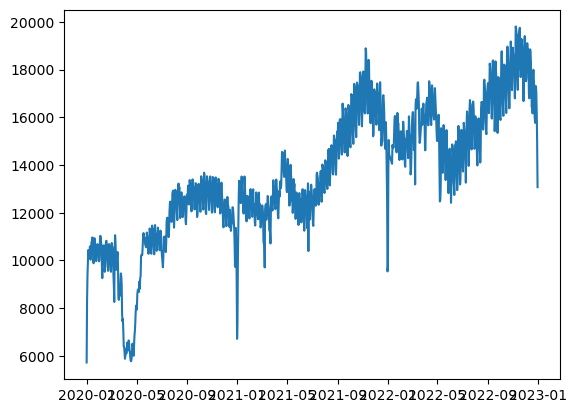

In [5]:
# Предобработка данных
data = data.drop_duplicates()
data = data.drop(data[data['y'] > 1000000].index)
data = data.drop(data[data['y'] < 5000].index)
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'])
data = data.drop(data.query('ds == "2022-01-10"').index)
data = data.drop(data.query('ds == "2022-12-31"').index)
plt.plot(data['ds'], data['y'])

In [6]:
data.index = pd.to_datetime(data['ds']) # Преобразуем индекс данных в формат даты и времени
data.tail()

ds      y
ds                          
2022-12-26 2022-12-26  17304
2022-12-27 2022-12-27  17042
2022-12-28 2022-12-28  16195
2022-12-29 2022-12-29  14966
2022-12-30 2022-12-30  13070

In [7]:
def ramadan(ds):# Функция для проверки, является ли дата частью месяца Рамадана
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime('2020-04-24') and date<= pd.to_datetime('2020-05-24')
           or date >= pd.to_datetime('2021-04-13') and date<= pd.to_datetime('2021-05-13')
           or date >= pd.to_datetime('2022-04-03') and date<= pd.to_datetime('2022-05-03')
           or date >= pd.to_datetime('2023-03-23') and date <= pd.to_datetime('2023-04-24'))
def corona(ds):# Функция для проверки, является ли дата частью периода пандемии коронавируса
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime('2020-03-18') and date<= pd.to_datetime('2020-05-11'))
data['is_ramadan'] = data['ds'].apply(ramadan)
data['is_corona'] = data['ds'].apply(corona)
data['ramadan'] = data['is_ramadan'].apply(int)
data['corona'] = data['is_corona'].apply(int)
data.head()

ds      y  is_ramadan  is_corona  ramadan  corona
ds                                                                  
2020-01-01 2020-01-01   5721       False      False        0       0
2020-01-02 2020-01-02   8274       False      False        0       0
2020-01-03 2020-01-03   9344       False      False        0       0
2020-01-04 2020-01-04   9864       False      False        0       0
2020-01-05 2020-01-05  10435       False      False        0       0

In [8]:
# Создаем датафрэйм для получения праздников в Казахстане на определенные года
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient = 'index').rename(columns = {0:'holiday'})
df_holidays['ds'] = df_holidays.index
df_holidays.tail()

holiday          ds
2023-12-16                Kazakhstan Independence Day  2023-12-16
2023-01-03                        New Year (observed)  2023-01-03
2023-05-08  Defender of the Fatherland Day (observed)  2023-05-08
2023-12-18     Kazakhstan Independence Day (observed)  2023-12-18
2023-06-28                     Kurban Ait (estimated)  2023-06-28

In [9]:
def get_mape(model, actual = data):# Функция для вычисления средней абсолютной процентной ошибки (MAPE)
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat'])
def plot (model, actual=data, threshold_changepoints = 0.01):# Функция для визуализации прогнозных и фактических данных с подсветкой изменений с помощью точек изменения
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis = 1)
    ax = df_plot[:].plot(y=['y', 'yhat'], kind='line', figsize = (15,10))
    a = add_changepoints_to_plot(ax, model, df_pred, threshold = threshold_changepoints)

In [10]:
data.shape

(1086, 6)

21:33:40 - cmdstanpy - INFO - Chain [1] start processing
21:33:40 - cmdstanpy - INFO - Chain [1] done processing
21:33:44 - cmdstanpy - INFO - Chain [1] start processing
21:33:44 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.3349396400042578)

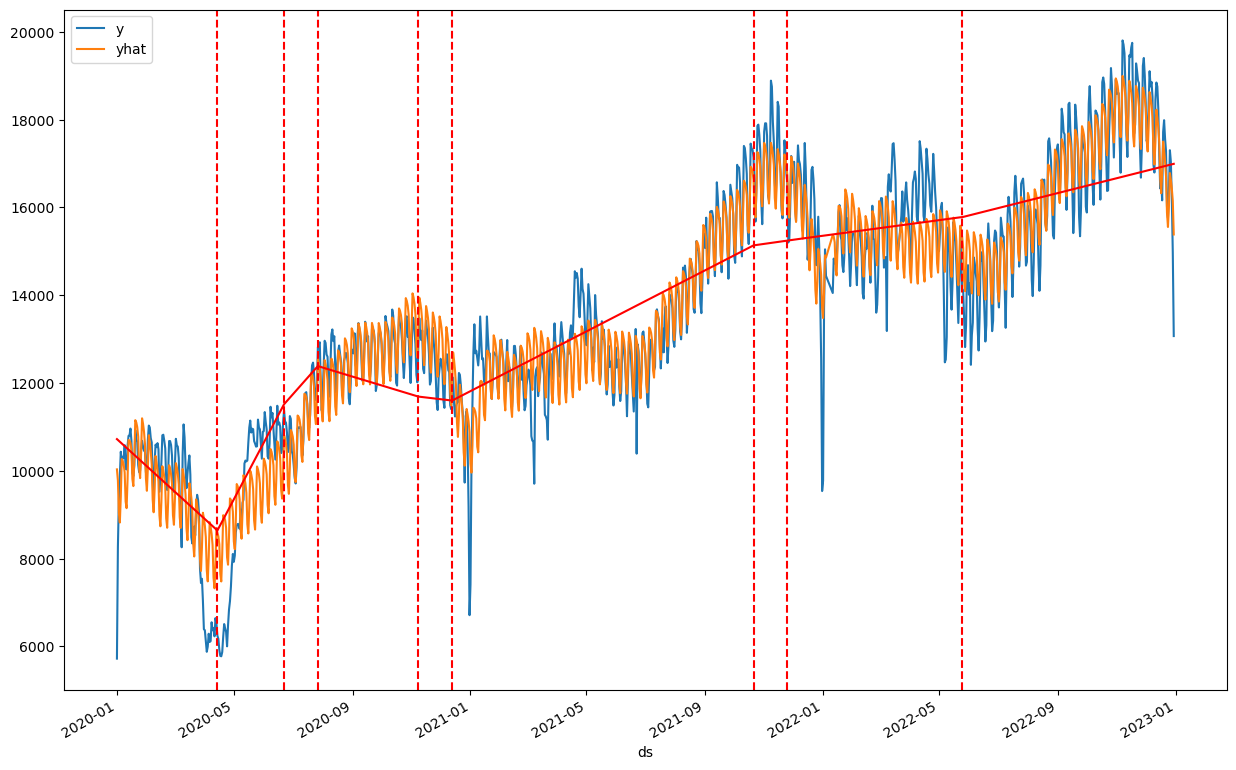

In [11]:
model = Prophet() # Инициализируем модель Prophet в качестве базовой
model.fit(data)
cv_results = cross_validation(model, initial = '731 days', period = '177 days', horizon = '355 days', parallel = 'processes')# Выполняем кросс-валидацию модели с указанием начального периода, периода, горизонта прогнозирования и параллельного выполнения
plot(model)# Визуализируем результаты кросс-валидации и вычисляем среднюю абсолютную процентную ошибку (MAPE)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

21:33:55 - cmdstanpy - INFO - Chain [1] start processing
21:33:55 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.36384097397645965)

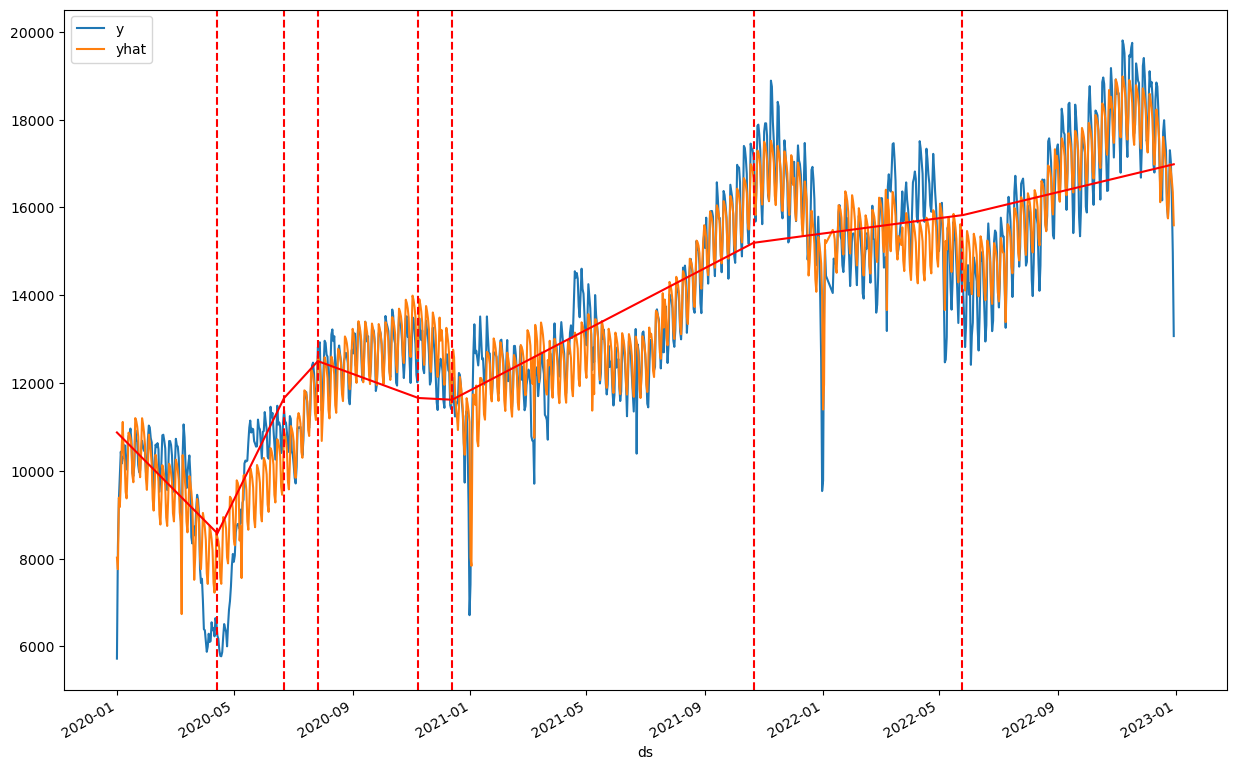

In [12]:
# Инициализируем модель Prophet с заданными параметрами (диапазоном точек изменения и праздниками), обучаем модель на данных и выполняем кросс-валидацию
model = Prophet(changepoint_range = 0.8, holidays = df_holidays)
model.fit(data)
cv_results = cross_validation(model, initial = '731 days', period = '178 days', horizon = '357 days', parallel = 'processes')
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

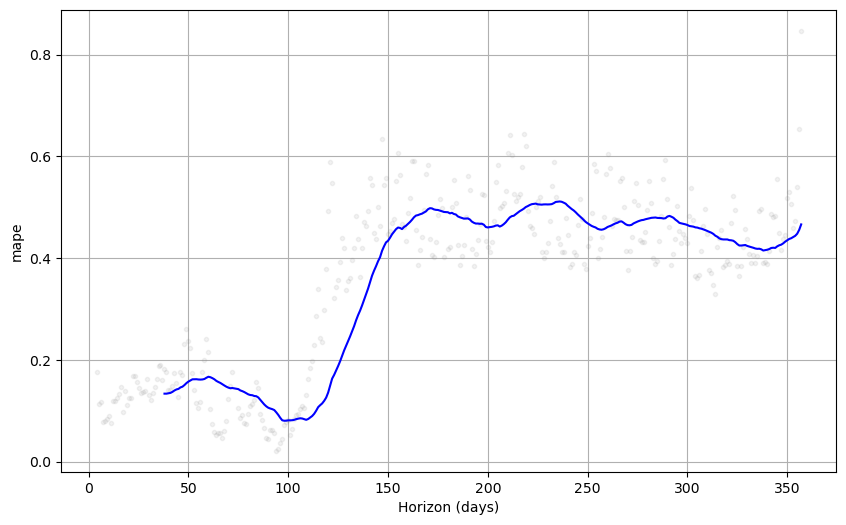

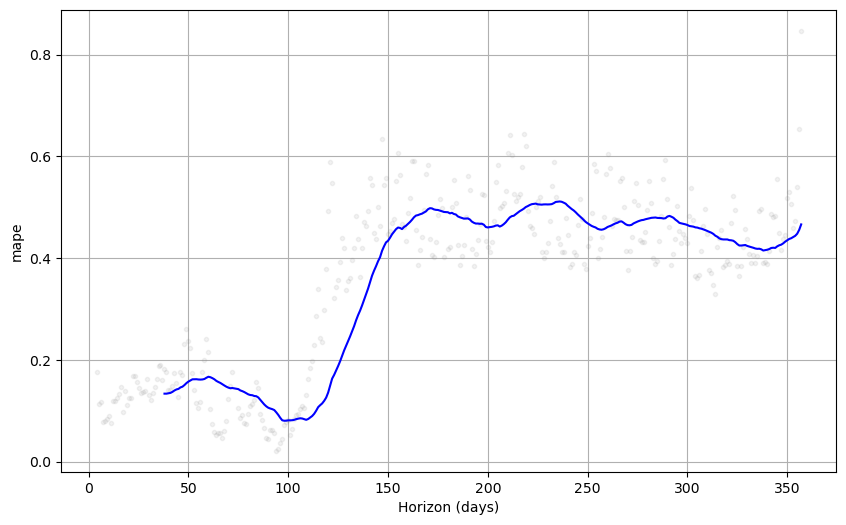

In [13]:
plot_cross_validation_metric(cv_results, metric = 'mape')# Визуализируем метрику кросс-валидации (MAPE) в зависимости от времени

21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:10 - cmdstanpy - INFO - Chain [1] start processing
21:34:10 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.2335000482753846)

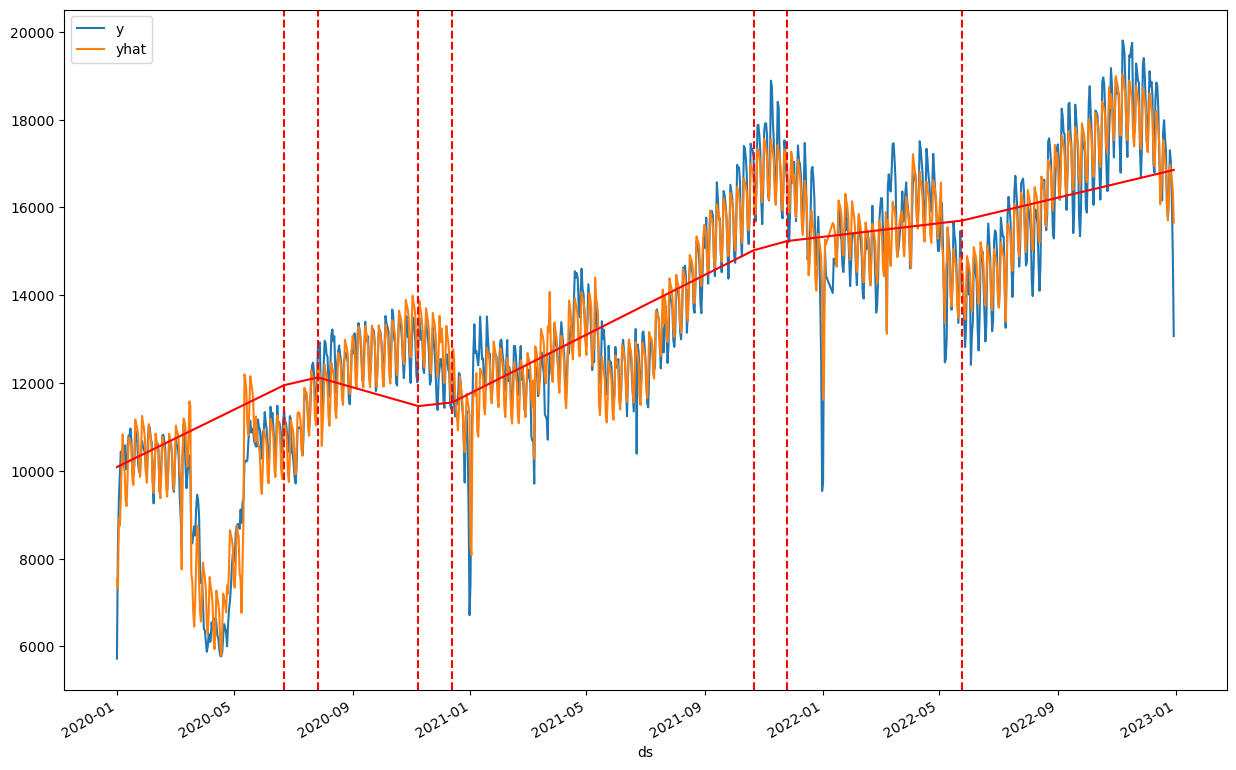

In [14]:
# Инициализируем модель Prophet с учетом регрессоров (признаков) 'ramadan' и 'corona', обучаем модель на данных и выполняем кросс-валидацию
model = Prophet(changepoint_range = 0.8, holidays = df_holidays).add_regressor('ramadan').add_regressor('corona')
model.fit(data)
cv_results = cross_validation(model, initial = '731 days', period = '177 days', horizon = '355 days', parallel = 'processes')
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

In [15]:
def train(params):# Определяем функцию для обучения модели Prophet с заданными параметрами и выполнения кросс-валидации
    model = Prophet(changepoint_range = 0.8, holidays = df_holidays, **params).add_regressor('ramadan').add_regressor('corona')
    model.fit(data)
    cv_results = cross_validation(model, initial = '731 days', period = '177 days', horizon = '355 days', parallel = 'processes')
    return np.average(performance_metrics(cv_results).mape.values)

In [16]:
# Определяем сетку параметров для оптимизации
param_grid = {
    'changepoint_prior_scale': np.logspace(0, 10, 5, base = 500**(1/10))/1000,
    'seasonality_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'holidays_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Создаем список всех комбинаций параметров
all_params

[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'holidays_prior_scale': 0.316227766016838},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'holidays_prior_scale': 1.0000000000000004},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'holidays_prior_scale': 3.162277660168381},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'holidays_prior_scale': 10.000000000000007},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.316227766016838,
  'holidays_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.316227766016838,
  'holidays_prior_scale': 0.316227766016838},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.316227766016838,
  'holidays_prior_scale': 1.0000000000000004},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prio

In [21]:
mapes = []# Создаем пустой список для хранения значений MAPE для всех комбинаций параметров
print(len(all_params))
for params in all_params:# Проходим по всем комбинациям параметров, вычисляем MAPE и сохраняем его в список mapes
    mapes.append(train(params))
best_params = all_params[np.argmin(mapes)]# Находим наилучшие параметры, соответствующие минимальному значению MAPE
print(best_params)
'MAPE', min(mapes)

125


15:39:19 - cmdstanpy - INFO - Chain [1] start processing
15:39:19 - cmdstanpy - INFO - Chain [1] done processing
15:39:21 - cmdstanpy - INFO - Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing
15:39:22 - cmdstanpy - INFO - Chain [1] start processing
15:39:22 - cmdstanpy - INFO - Chain [1] done processing
15:39:24 - cmdstanpy - INFO - Chain [1] start processing
15:39:24 - cmdstanpy - INFO - Chain [1] done processing
15:39:25 - cmdstanpy - INFO - Chain [1] start processing
15:39:25 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:27 - cmdstanpy - INFO - Chain [1] start processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:29 - cmdstanpy - INFO - Chain [1] start processing
15:39:29 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1]

15:40:49 - cmdstanpy - INFO - Chain [1] done processing
15:40:51 - cmdstanpy - INFO - Chain [1] start processing
15:40:51 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
15:40:54 - cmdstanpy - INFO - Chain [1] start processing
15:40:54 - cmdstanpy - INFO - Chain [1] done processing
15:40:55 - cmdstanpy - INFO - Chain [1] start processing
15:40:55 - cmdstanpy - INFO - Chain [1] done processing
15:40:56 - cmdstanpy - INFO - Chain [1] start processing
15:40:56 - cmdstanpy - INFO - Chain [1] done processing
15:40:57 - cmdstanpy - INFO - Chain [1] start processing
15:40:57 - cmdstanpy - INFO - Chain [1] done processing
15:40:58 - cmdstanpy - INFO - Chain [1] start processing
15:40:58 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] 

15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:06 - cmdstanpy - INFO - Chain [1] done processing
15:42:07 - cmdstanpy - INFO - Chain [1] start processing
15:42:07 - cmdstanpy - INFO - Chain [1] done processing
15:42:08 - cmdstanpy - INFO - Chain [1] start processing
15:42:08 - cmdstanpy - INFO - Chain [1] done processing
15:42:09 - cmdstanpy - INFO - Chain [1] start processing
15:42:09 - cmdstanpy - INFO - Chain [1] done processing
15:42:10 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1]

15:43:37 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:40 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing
15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing
15:43:50 - cmdstanpy - INFO - Chain [1] start processing
15:43:51 - cmdstanpy - INFO - Chain [1] done processing
15:43:52 - cmdstanpy - INFO - Chain [1] 

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 3.162277660168381, 'holidays_prior_scale': 0.316227766016838}


('MAPE', 0.051553299864209506)

21:34:22 - cmdstanpy - INFO - Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing
21:34:25 - cmdstanpy - INFO - Chain [1] start processing
21:34:25 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.051553299864209506)

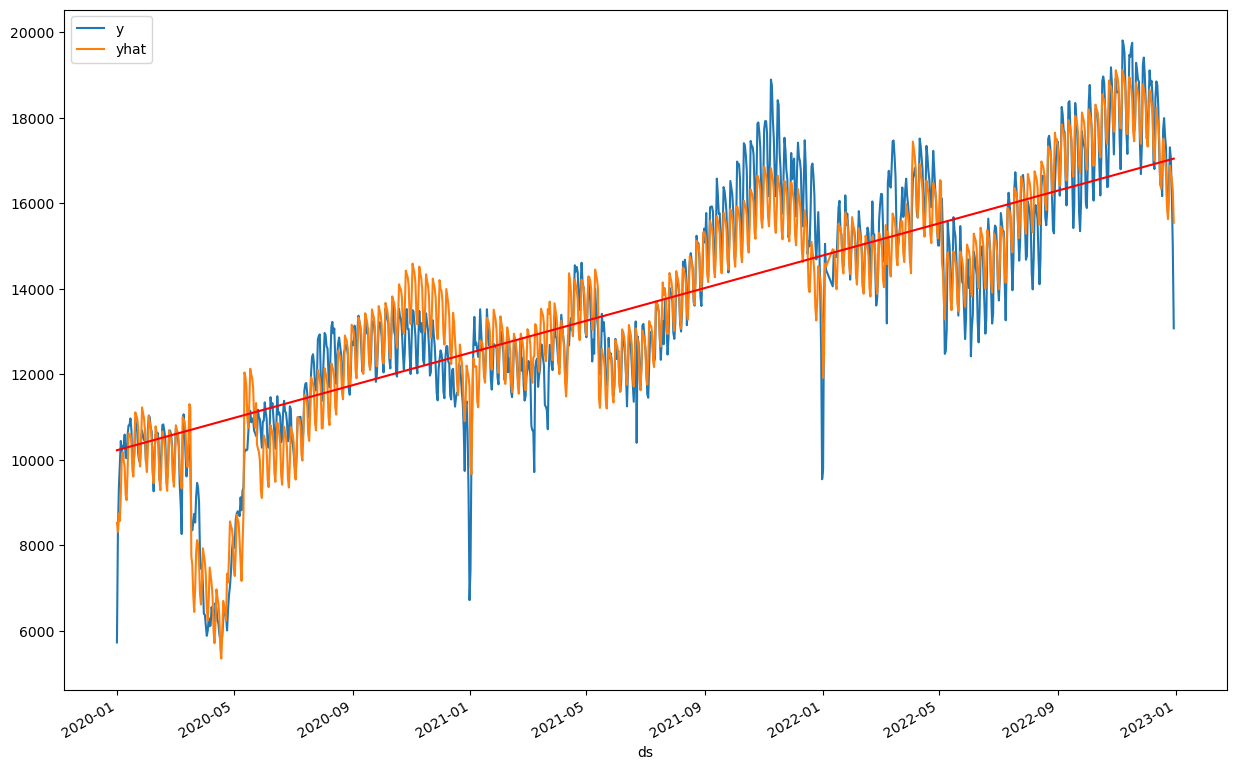

In [17]:
best_params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 3.162277660168381, 'holidays_prior_scale': 0.316227766016838}
model = Prophet(changepoint_range = 0.8, holidays = df_holidays, **best_params).add_regressor('ramadan').add_regressor('corona')
model.fit(data)
cv_results = cross_validation(model, initial = '731 days', period = '177 days', horizon = '355 days', parallel = 'processes')
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

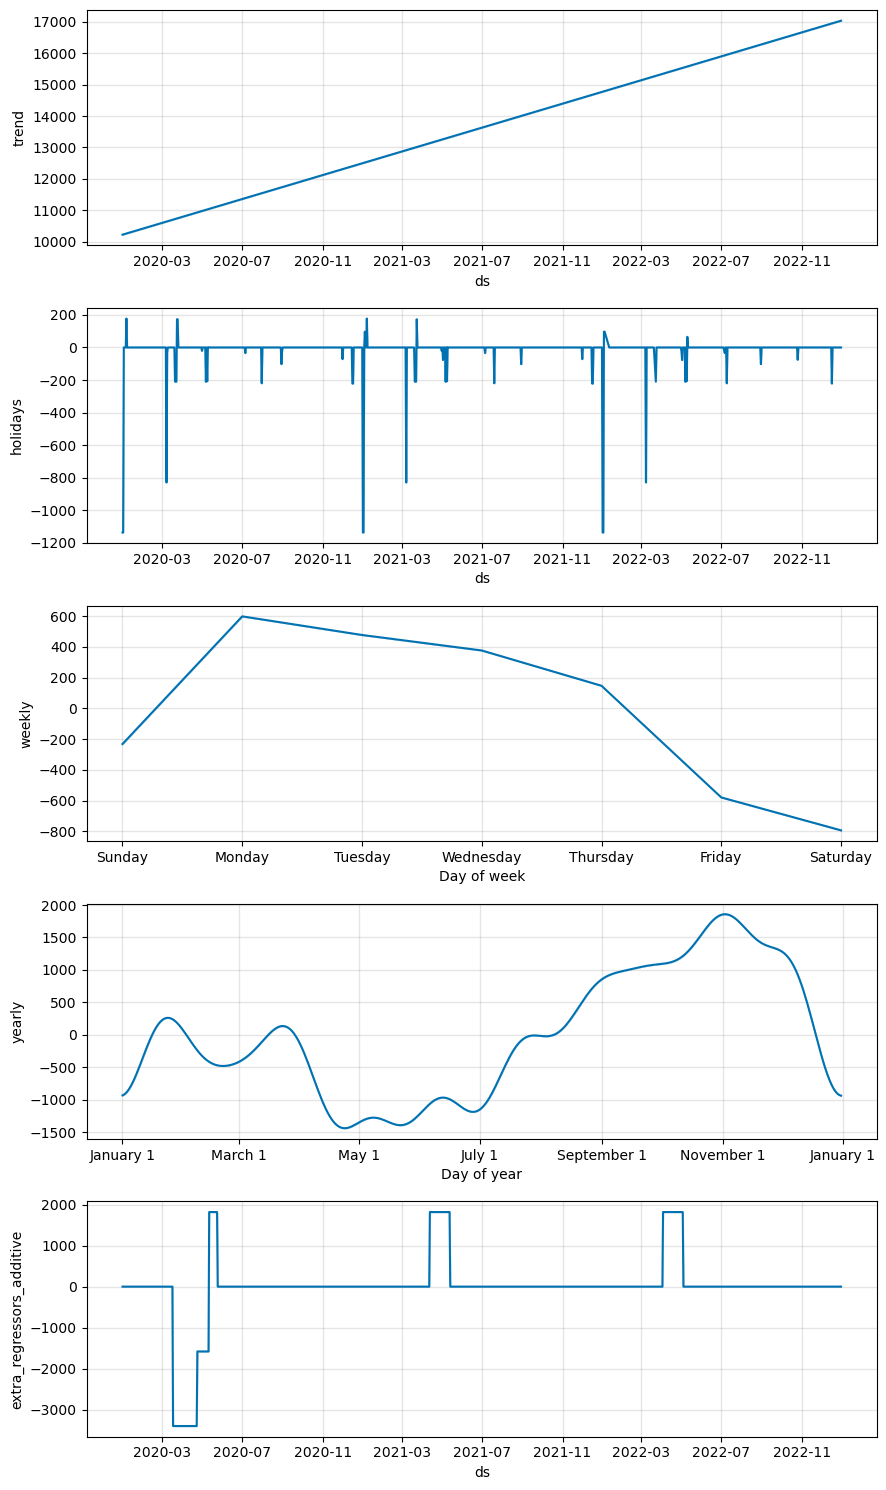

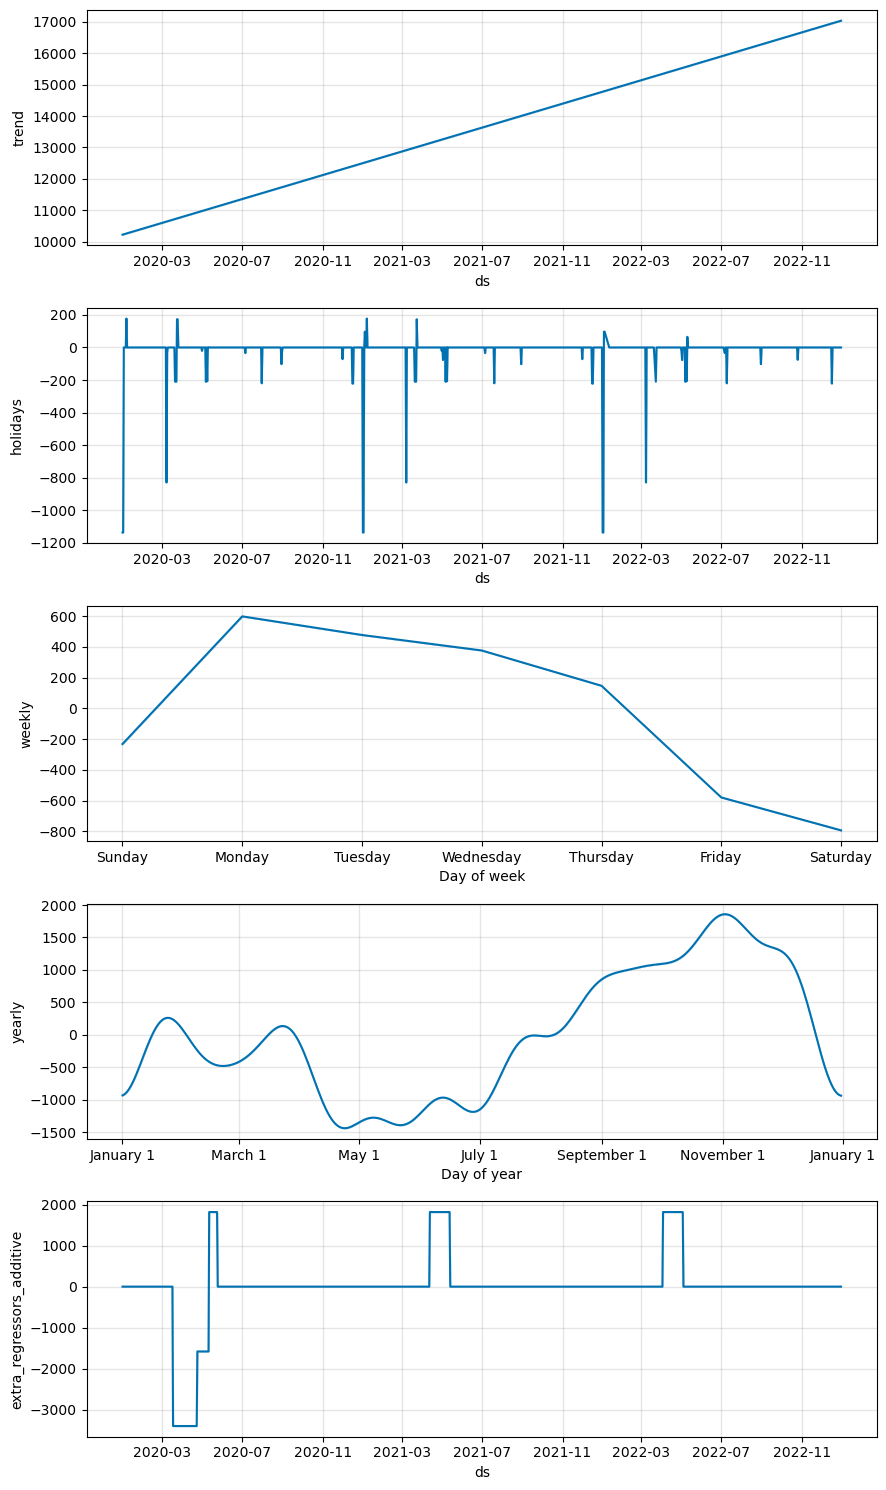

In [22]:
model.plot_components(model.predict(data))# Визуализируем компоненты прогноза (тренд, сезонность и праздники)

In [18]:
# Разделяем данные на обучающую и тестовую выборки
train = data[:731]
test = data[731:]
train

ds      y  is_ramadan  is_corona  ramadan  corona
ds                                                                  
2020-01-01 2020-01-01   5721       False      False        0       0
2020-01-02 2020-01-02   8274       False      False        0       0
2020-01-03 2020-01-03   9344       False      False        0       0
2020-01-04 2020-01-04   9864       False      False        0       0
2020-01-05 2020-01-05  10435       False      False        0       0
...               ...    ...         ...        ...      ...     ...
2021-12-27 2021-12-27  15789       False      False        0       0
2021-12-28 2021-12-28  15097       False      False        0       0
2021-12-29 2021-12-29  13955       False      False        0       0
2021-12-30 2021-12-30  12539       False      False        0       0
2021-12-31 2021-12-31   9539       False      False        0       0

[731 rows x 6 columns]

21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:46 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.051553299864209506)

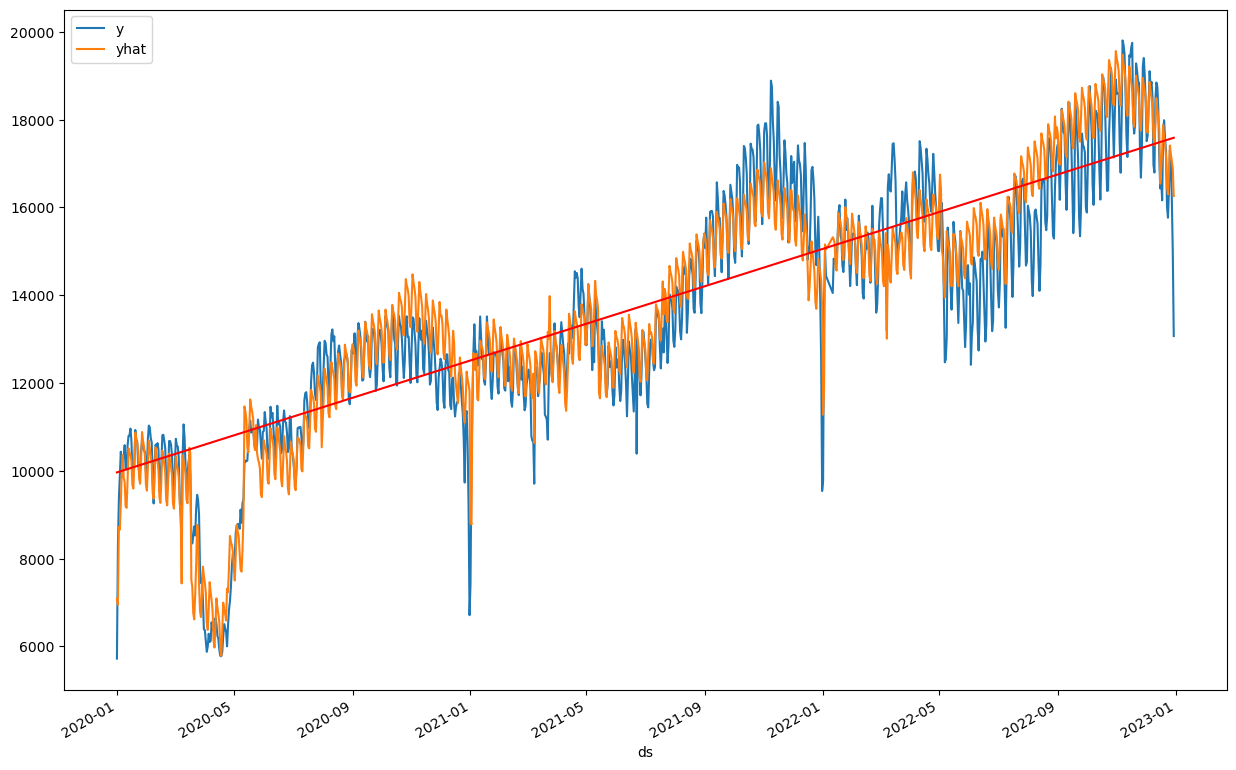

In [19]:
model = Prophet(changepoint_range = 0.8, holidays = df_holidays, **best_params).add_regressor('ramadan').add_regressor('corona')
model.fit(train)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

In [20]:
test = test[['ds', 'ramadan', 'corona']]
predict_data = test.reset_index(drop=True)
actual_data = data[731:][['ds', 'y']].reset_index(drop=True)

In [21]:
# Прогнозируем значения на тестовой выборке
predicted_data = model.predict(predict_data)

In [22]:
mean_absolute_percentage_error(actual_data.y, predicted_data.yhat)

0.049053095258643487

In [23]:
np.mean(actual_data.y-predicted_data.yhat)

-394.8423647644036

In [24]:
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      355 non-null    datetime64[ns]
 1   y       355 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 6.0 KB


In [25]:
# Объединяем фактические и прогнозные данные для анализа остатков
merged_data = actual_data.merge(predicted_data[['ds', 'yhat']], how = 'left', on = 'ds')
merged_data['residuals'] = merged_data['y']-merged_data['yhat']
np.mean(merged_data['residuals'])

-394.8423647644036

<Axes: >

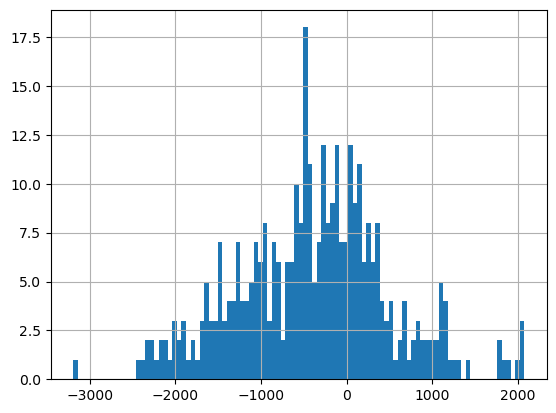

In [26]:
merged_data.residuals.hist(bins = 100)# Визуализируем распределение остатков

In [27]:
merged_data[merged_data['residuals'] < -2500]

ds      y          yhat    residuals
354 2022-12-30  13070  16260.444473 -3190.444473

In [28]:
# Инициализируем модель Prophet с оптимальными параметрами, праздниками и регрессорами (признаками), обучаем модель на всех имеющихся данных
model = Prophet(changepoint_range = 0.8, holidays = df_holidays, **best_params).add_regressor('ramadan').add_regressor('corona')
model.fit(data)

21:35:47 - cmdstanpy - INFO - Chain [1] start processing
21:35:47 - cmdstanpy - INFO - Chain [1] done processing


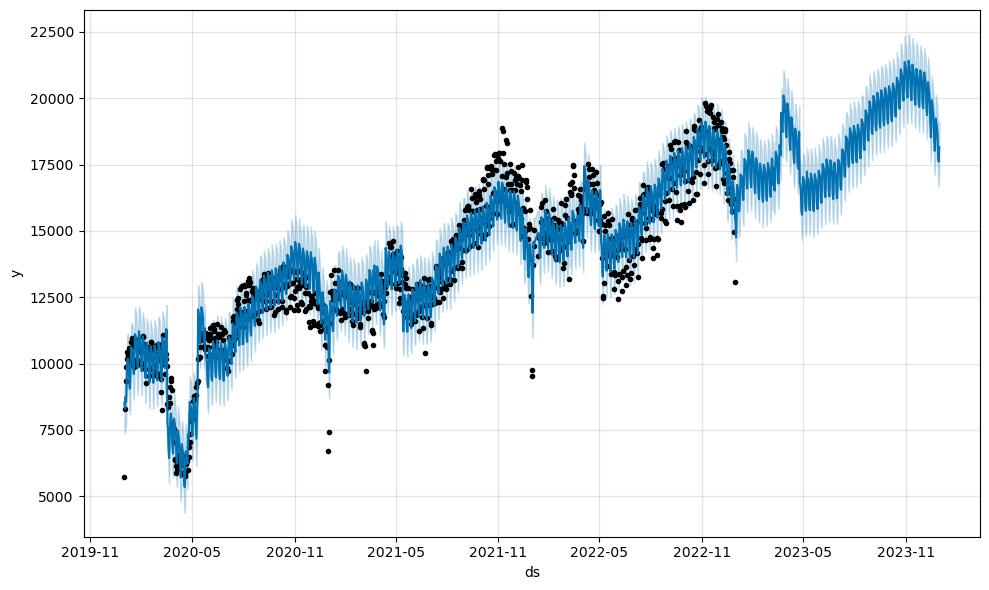

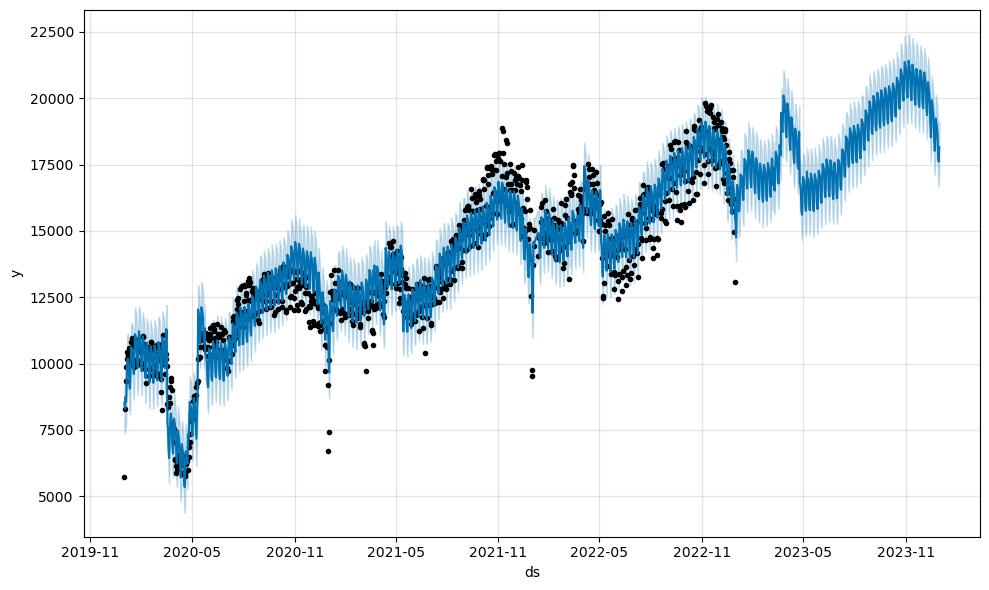

In [31]:
# Создаем DataFrame для прогнозирования на 2023 год с учетом дополнительных признаков (Рамадана и коронавируса)
ds_2023 = model.make_future_dataframe(366,include_history=True)
ds_2023['is_ramadan'] = ds_2023['ds'].apply(ramadan)
ds_2023['is_corona'] = ds_2023['ds'].apply(corona)
ds_2023['ramadan'] = ds_2023['is_ramadan'].apply(int)
ds_2023['corona'] = ds_2023['is_corona'].apply(int)
predict2023 = model.predict(ds_2023)# Прогнозируем значения на 2023 год
model.plot(predict2023)# Визуализируем прогнозные значения для 2023 года

In [33]:
predict2023 = predict2023[predict2023['ds'].dt.year == 2023]
predict2023

ds         trend    yhat_lower    yhat_upper   trend_lower  \
1087 2023-01-01  17052.509661  13845.628349  15725.665789  17052.509661   
1088 2023-01-02  17058.745354  14724.551482  16523.935293  17058.745354   
1089 2023-01-03  17064.981047  15872.118108  17654.588859  17064.981047   
1090 2023-01-04  17071.216739  15552.351000  17532.996167  17071.216739   
1091 2023-01-05  17077.452432  15503.400688  17292.485311  17077.452432   
1092 2023-01-06  17083.688124  14732.131747  16614.186230  17083.688124   
1093 2023-01-07  17089.923817  14822.638327  16687.926617  17089.923817   
1094 2023-01-08  17096.159510  15304.464133  17175.579683  17096.159508   
1095 2023-01-09  17102.395202  16170.815779  18037.904931  17102.395198   
1096 2023-01-10  17108.630895  16185.229495  18038.979503  17108.630887   
1097 2023-01-11  17114.866587  16142.544622  18071.391332  17114.866575   
1098 2023-01-12  17121.102280  15962.218197  17885.016619  17121.102262   
1099 2023-01-13  17127.337973  15362.711836  17238.809017  17127.337951   
1100 2023-01-14  17133.573665  15182.938100  17076.802411  17133.573637   
1101 2023-01-15  17139.809358  15875.608431  17740.962571  17139.809317   
1102 2023-01-16  17146.045050  16812.989724  18698.492610  17146.044999   
1103 2023-01-17  17152.280743  16734.546567  18603.520675  17152.280682   
1104 2023-01-18  17158.516436  16642.559157  18561.107749  17158.516365   
1105 2023-01-19  17164.752128  16452.572884  18366.088464  17164.752048   
1106 2023-01-20  17170.987821  15779.506919  17764.643015  17170.987733   
1107 2023-01-21  17177.223514  15680.213581  17603.311813  17177.223408   
1108 2023-01-22  17183.459206  16291.187947  18179.893806  17183.459088   
1109 2023-01-23  17189.694899  17148.602538  19097.418064  17189.694768   
1110 2023-01-24  17195.930591  16986.413672  18862.460553  17195.930446   
1111 2023-01-25  17202.166284  16864.882150  18896.603980  17202.166128   
1112 2023-01-26  17208.401977  16617.686171  18559.710104  17208.401804   
1113 2023-01-27  17214.637669  15972.709700  17789.184470  17214.637481   
1114 2023-01-28  17220.873362  15736.119131  17627.709636  17220.873162   
1115 2023-01-29  17227.109054  16278.419489  18115.964453  17227.108836   
1116 2023-01-30  17233.344747  17007.587540  18907.757488  17233.344519   
1117 2023-01-31  17239.580440  16889.630352  18844.969917  17239.580195   
1118 2023-02-01  17245.816132  16731.012448  18641.753890  17245.815873   
1119 2023-02-02  17252.051825  16486.621720  18419.676939  17252.051546   
1120 2023-02-03  17258.287517  15798.311561  17576.500474  17258.287226   
1121 2023-02-04  17264.523210  15462.854291  17364.462523  17264.522906   
1122 2023-02-05  17270.758903  15980.718117  17896.916031  17270.758582   
1123 2023-02-06  17276.994595  16748.514251  18750.908232  17276.994258   
1124 2023-02-07  17283.230288  16541.424171  18557.307944  17283.229937   
1125 2023-02-08  17289.465981  16517.204693  18437.264371  17289.465616   
1126 2023-02-09  17295.701673  16221.458578  18200.072302  17295.701289   
1127 2023-02-10  17301.937366  15514.230874  17374.287033  17301.936976   
1128 2023-02-11  17308.173058  15311.763981  17126.026165  17308.172647   
1129 2023-02-12  17314.408751  15845.839309  17651.720926  17314.408315   
1130 2023-02-13  17320.644444  16638.801079  18454.471721  17320.643989   
1131 2023-02-14  17326.880136  16486.836789  18385.644613  17326.879661   
1132 2023-02-15  17333.115829  16325.001331  18158.694411  17333.115342   
1133 2023-02-16  17339.351521  16121.033510  18069.582143  17339.351013   
1134 2023-02-17  17345.587214  15375.921372  17236.008734  17345.586694   
1135 2023-02-18  17351.822907  15128.326598  17083.523600  17351.822367   
1136 2023-02-19  17358.058599  15717.458839  17615.168498  17358.058042   
1137 2023-02-20  17364.294292  16499.325833  18411.664630  17364.293711   
1138 2023-02-21  17370.529984  16373.235951  18286.823643  17370.529384   
1139 2023-02-22  17376.765677  16321.8

In [35]:
predict2023[['ds', 'yhat']].to_excel('output_p.xlsx', index=False)